## Imports

In [131]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import calendar
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from geopy.distance import geodesic
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

## Utils

In [132]:
def get_days_in_month(year, month):
    _, num_days = calendar.monthrange(year, month)
    return num_days

def get_day_in_year(year, month, day):
    day_in_year = 0

    for m in range(1, month):
        day_in_year += get_days_in_month(year, m)

    day_in_year += day - 1

    return day_in_year

def add_hour_features(df):
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    
    return df
def add_day_in_year_features(df):
    # Convertir la variable 'day_in_year' a variables cícliches
    df['day_in_year_sin'] = np.sin(2 * np.pi * df['day_in_year'] / 365)
    df['day_in_year_cos'] = np.cos(2 * np.pi * df['day_in_year'] / 365)
    
    return df

def add_time_features(df):
    df = add_hour_features(df)
    
    df = add_day_in_year_features(df)
    
    return df

def acostar_a_1(x, factor=0.1):
    return x + (1 - x) * factor

## Dades

In [133]:
observations = pd.read_csv("../Data/gene_sconcno2_2023_xvpca_emep_port.csv")
stations_info = pd.read_csv("../Data/XVPCA_info_sconcno2_2023.csv")

In [134]:
observations_transformed = observations.melt(id_vars=["Date"], var_name="Station", value_name="concentration")

stations_info.rename(columns={"code": "Station", "lat": "Latitude", "lon": "Longitude"}, inplace=True)
observations_transformed = observations_transformed.merge(stations_info, on="Station", how="left")

observations_transformed = observations_transformed[["Date", "Latitude", "Longitude", "concentration"]]
observations_transformed.rename(columns={"Date": "date", "Latitude": "lat", "Longitude": "lon"}, inplace=True)

# Eliminar files amb valors NaN en lat, lon o concentració
observations_transformed.dropna(subset=["lat", "lon", "concentration"], inplace=True)

In [135]:
observations_transformed

,date,lat,lon,concentration
1,2023-01-01 00:00:00,41.317277,2.134501,19.50
2,2023-01-01 01:00:00,41.317277,2.134501,18.50
3,2023-01-01 02:00:00,41.317277,2.134501,18.20
4,2023-01-01 03:00:00,41.317277,2.134501,22.60
5,2023-01-01 04:00:00,41.317277,2.134501,16.60
...,...,...,...,...
560612,2023-12-30 19:00:00,41.393887,0.734722,6.55
560613,2023-12-30 20:00:00,41.393887,0.734722,5.07
560614,2023-12-30 21:00:00,41.393887,0.734722,3.59
560615,2023-12-30 22:00:00,41.393887,0.734722,3.19


In [136]:
average_concentration = observations_transformed["concentration"].mean()
average_concentration

16.075015088271584

In [137]:
data_transformed = observations_transformed.copy()

data_transformed['date'] = pd.to_datetime(data_transformed['date'])

data_transformed['day_in_year'] = data_transformed.apply(
    lambda row: get_day_in_year(row['date'].year, row['date'].month, row['date'].day), axis=1
)
data_transformed['hour'] = data_transformed['date'].dt.hour

data_transformed = data_transformed.drop(columns=['date'])

print("Exemple Data Transformed:")
data_transformed.iloc[9999]

Exemple Data Transformed:


lat              41.385366
lon               2.154030
concentration    27.000000
day_in_year      99.000000
hour              6.000000
Name: 11143, dtype: float64

In [138]:
data_final = add_time_features(data_transformed)

data_final = data_final.drop(columns=["day_in_year", "hour"])

print(data_final.head())

         lat       lon  concentration  hour_sin  hour_cos  day_in_year_sin  \
1  41.317277  2.134501           19.5  0.000000  1.000000              0.0   
2  41.317277  2.134501           18.5  0.258819  0.965926              0.0   
3  41.317277  2.134501           18.2  0.500000  0.866025              0.0   
4  41.317277  2.134501           22.6  0.707107  0.707107              0.0   
5  41.317277  2.134501           16.6  0.866025  0.500000              0.0   

   day_in_year_cos  
1              1.0  
2              1.0  
3              1.0  
4              1.0  
5              1.0  


In [139]:
X = data_final[['hour_sin', 'hour_cos', 'day_in_year_sin', 'day_in_year_cos']]
y = data_final['concentration']

In [140]:
y_mean = y.mean()

# Normalitzar y basat en la mitjana
y_normalized = (y - y_mean) / y_mean

# Dividir les dades en entrenament i test
X_train, X_test, y_train, y_test = train_test_split(X, y_normalized, test_size=0.2, random_state=42)

# Transformació polinòmica i regressió lineal
poly = PolynomialFeatures(degree=7, include_bias=False)
model = make_pipeline(poly, LinearRegression())

# Entrenar el model
model.fit(X_train, y_train)

# Predir valors (normalitzats)
y_pred_normalized = model.predict(X_test)

# Calcul de l'MSE
mse = mean_squared_error(y_test, y_pred_normalized)
print("MSE (normalitzat):", mse)

# Mostrar les prediccions normalitzades
print("Prediccions normalitzades (mitjana):", y_pred_normalized[:5])

# Desnormalitzar les prediccions
y_pred_original = y_pred_normalized * y_mean + y_mean
print("Prediccions desnormalitzades:", y_pred_original[:5])

MSE (normalitzat): 0.8037392289394265
Prediccions normalitzades (mitjana): [-0.25860596  0.20080566  0.41171265 -0.21841431  0.55924988]
Prediccions desnormalitzades: [11.91792043 19.30296917 22.69330209 12.56400181 25.06496531]


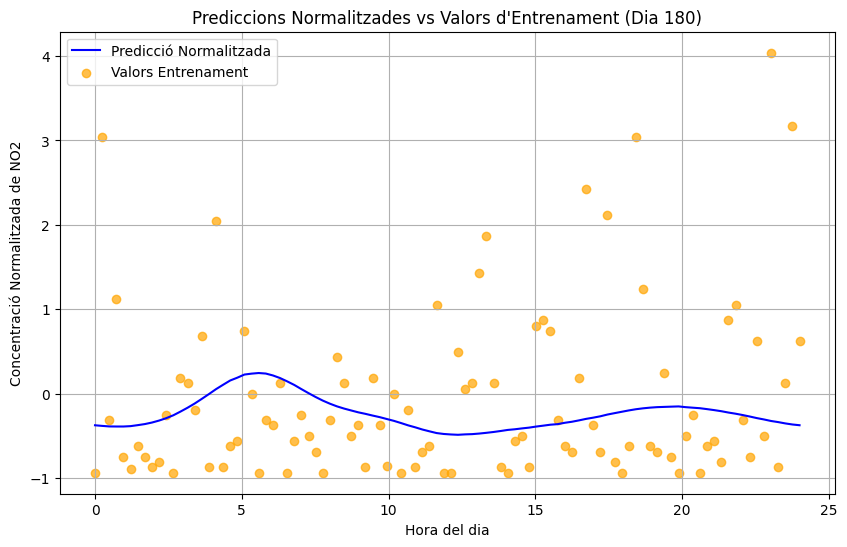

In [141]:
day_of_year = 180
hour = np.linspace(0, 24, 100)

hour_sin = np.sin(2 * np.pi * hour / 24)
hour_cos = np.cos(2 * np.pi * hour / 24)
day_sin = np.sin(2 * np.pi * day_of_year / 365)
day_cos = np.cos(2 * np.pi * day_of_year / 365)

X_day = pd.DataFrame({
    'hour_sin': hour_sin,
    'hour_cos': hour_cos,
    'day_in_year_sin': [day_sin] * len(hour),
    'day_in_year_cos': [day_cos] * len(hour),
})

y_pred_day = model.predict(X_day)
y_train_sample = y_train[:len(hour)]  # Considerem només els primers valors

# Gràfic corregit
plt.figure(figsize=(10, 6))

# Gràfic de prediccions
plt.plot(hour, y_pred_day, label='Predicció Normalitzada', color='blue')

# Gràfic de valors d'entrenament
plt.scatter(hour[:len(y_train_sample)], y_train_sample, label='Valors Entrenament', color='orange', alpha=0.7)

# Estil del gràfic
plt.title(f"Prediccions Normalitzades vs Valors d'Entrenament (Dia {day_of_year})")
plt.xlabel("Hora del dia")
plt.ylabel("Concentració Normalitzada de NO2")
plt.legend()
plt.grid()
plt.show()


In [142]:
def filter_by_radius(data_transformed, center_lat, center_lon, radius_km):
    def is_within_radius(row):
        center = (center_lat, center_lon)
        point = (row["lat"], row["lon"])
        return geodesic(center, point).km <= radius_km

    filtered_df = data_transformed[data_transformed.apply(is_within_radius, axis=1)]
    return filtered_df

In [143]:
locations = [(41.39216, 2.009802), (41.11588, 1.191975), (41.44398, 2.237875), (41.32177, 2.082141)]

datasets_near = []
for lat, lon in locations:
    observations_near = filter_by_radius(data_transformed, lat, lon, 5)
    datasets_near.append((lat, lon, observations_near))

In [144]:
datasets_near[0]

(41.39216,
 2.009802,
               lat       lon  concentration  day_in_year  hour  hour_sin  \
 131400  41.400771  1.999635           29.0          364    23 -0.258819   
 131401  41.400771  1.999635           34.0            0     0  0.000000   
 131402  41.400771  1.999635           35.0            0     1  0.258819   
 131403  41.400771  1.999635           33.0            0     2  0.500000   
 131404  41.400771  1.999635           29.0            0     3  0.707107   
 ...           ...       ...            ...          ...   ...       ...   
 148915  41.415319  1.990521            8.0          364    18 -1.000000   
 148916  41.415319  1.990521           15.0          364    19 -0.965926   
 148917  41.415319  1.990521           17.0          364    20 -0.866025   
 148918  41.415319  1.990521           20.0          364    21 -0.707107   
 148919  41.415319  1.990521           24.0          364    22 -0.500000   
 
             hour_cos  day_in_year_sin  day_in_year_cos  
 13140

In [162]:
models = []

for lat, lon, dataset_near in datasets_near:
    X = dataset_near[['hour_sin', 'hour_cos', 'day_in_year_sin', 'day_in_year_cos']]
    y = dataset_near['concentration']
    
    y_mean = y.mean()
    y_normalized = (y - y_mean) / y_mean
    
    poly = PolynomialFeatures(degree=7, include_bias=True)
    model = make_pipeline(poly, LinearRegression())
    
    model.fit(X, y_normalized)
    models.append((lat, lon, model, y_mean))

In [163]:
dates = pd.date_range(start="2023-01-01 00:00", end="2023-12-31 23:00", freq="H")

data = []
id_counter = 1

# Iterem per cada dataset de les zones properes
for lat, lon, dataset_near in datasets_near:
    # Obtenir el model corresponent
    model_info = next((m for m in models if m[0] == lat and m[1] == lon), None)
    if model_info is None:
        raise ValueError(f"No s'ha trobat un model per a la location ({lat}, {lon})")
    
    model, y_mean = model_info[2], model_info[3]

    # Calcular la concentració mitjana
    avg_concentration = dataset_near["concentration"].mean()
    
    for date in dates:
        # Característiques cíclices
        hour = date.hour
        day_of_year = date.timetuple().tm_yday
        
        hour_sin = np.sin(2 * np.pi * hour / 24)
        hour_cos = np.cos(2 * np.pi * hour / 24)
        day_sin = np.sin(2 * np.pi * day_of_year / 365)
        day_cos = np.cos(2 * np.pi * day_of_year / 365)
        
        # Crear el DataFrame per predir
        X_single = pd.DataFrame({
            'hour_sin': [hour_sin],
            'hour_cos': [hour_cos],
            'day_in_year_sin': [day_sin],
            'day_in_year_cos': [day_cos],
        })
        
        # Predir el coeficient
        time_coeficient_normalized = model.predict(X_single)[0]
        time_coeficient = time_coeficient_normalized 
        
        data.append({
            "id": id_counter,
            "date": date.strftime("%Y-%m-%d %H:%M"),
            "lat": lat, 
            "lon": lon, 
            "concentration": avg_concentration + (time_coeficient * avg_concentration)
        })
        id_counter += 1

# Crear el DataFrame final
output_df = pd.DataFrame(data)

# Guardar en un arxiu CSV
output_csv_path = "output_concentration.csv"
output_df.to_csv(output_csv_path, index=False)

print(f"Arxiu generat: {output_csv_path}")

C:\Users\p2004\AppData\Local\Temp\ipykernel_2488\3100303948.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(start="2023-01-01 00:00", end="2023-12-31 23:00", freq="H")


Arxiu generat: output_concentration.csv


In [164]:
#pd.set_option('display.max_rows', 100)
#output_df.head(100)
output_df


,id,date,lat,lon,concentration
0,1,2023-01-01 00:00,41.39216,2.009802,28.555568
1,2,2023-01-01 01:00,41.39216,2.009802,26.367248
2,3,2023-01-01 02:00,41.39216,2.009802,24.290805
3,4,2023-01-01 03:00,41.39216,2.009802,22.903526
4,5,2023-01-01 04:00,41.39216,2.009802,22.563419
...,...,...,...,...,...
35035,35036,2023-12-31 19:00,41.32177,2.082141,44.347832
35036,35037,2023-12-31 20:00,41.32177,2.082141,42.380826
35037,35038,2023-12-31 21:00,41.32177,2.082141,39.174257
35038,35039,2023-12-31 22:00,41.32177,2.082141,35.141314
